# Pattern Matching on Sensor Data

<div class="alert alert-block alert-info">
<b>Tip:</b> We have new features for highly optimized time series analytics.

See documentation and notebooks on ***Temporal Similarity Search (TSS):***

- Transformed TSS: [Documentation](https://code.kx.com/kdbai/reference/transformed-tss.html) | [Notebook](https://github.com/KxSystems/kdbai-samples/blob/main/TSS_transformed/Temporal_Similarity_Search_Transformed_Demo.ipynb)

- Non-Transformed TSS: [Documentation](https://code.kx.com/kdbai/use/non-transformed-tss.html) | [Notebook](https://github.com/KxSystems/kdbai-samples/blob/main/TSS_non_transformed/Temporal_Similarity_Search_Non-Transformed_Demo.ipynb)

</div>

##### Note: This example requires a KDB.AI endpoint and API key. Sign up for a free [KDB.AI account](https://kdb.ai/get-started).

This example explores the process of conducting pattern matching on time series manufacturing data using a similarity search in KDB.AI.

Our goal is to identify and retrieve historical time series that exhibit specific patterns. This matching capability is instrumental in a wide array of manufacturing scenarios, including quality control, process optimization, and predictive maintenance. For instance, imagine a scenario where we have time series data representing machinery performance, and we need to pinpoint instances of unusual behaviour, such as spikes, drops, or recurring trends.

We will guide you through a straightforward approach that leverages the raw time series data directly, without the need for complex modelling or domain-specific expertise. This approach is particularly attractive because it doesn't require additional resources for model creation. The sample will demonstrate that this simplistic method can yield satisfactory results.

### Aim

This tutorial will walk through the process of storing time series data in a vector database, using windowing and normalization to generate simple time series vector embeddings. We will use KDB.AI's vector database to find historical patterns that match an input query pattern. We will cover the following topics:

1. Load Sensor Data
1. Create Sensor Vector Embeddings
1. Store Embeddings in KDB.AI
1. Search For Similar Sequences To A Target Sensor Sequence
1. Delete the KDB.AI Table

---

## 0. Setup

### Install dependencies

In order to successfully run this sample, note the following steps depending on where you are running this notebook:

-***Run Locally / Private Environment:*** The [Setup](https://github.com/KxSystems/kdbai-samples/blob/main/README.md#setup) steps in the repository's `README.md` will guide you on prerequisites and how to run this with Jupyter.


-***Colab / Hosted Environment:*** Open this notebook in Colab and run through the cells.

In [ ]:
!pip install kdbai_client matplotlib

In [ ]:
### !!! Only run this cell if you need to download the data into your environment, for example in Colab
### This downloads sensor data
!mkdir ./data
!wget -P ./data https://raw.githubusercontent.com/KxSystems/kdbai-samples/main/pattern_matching/data/archive.zip

mkdir: cannot create directory ‘./data’: File exists
--2024-07-26 18:23:43--  https://raw.githubusercontent.com/KxSystems/kdbai-samples/main/pattern_matching/data/archive.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 38873832 (37M) [application/zip]
Saving to: ‘./data/archive.zip.1’

archive.zip.1       100%[===================>]  37.07M  68.1MB/s    in 0.5s    

2024-07-26 18:23:44 (68.1 MB/s) - ‘./data/archive.zip.1’ saved [38873832/38873832]



### Import Packages

In [ ]:
# read data
from zipfile import ZipFile
import pandas as pd

In [ ]:
# plotting
import matplotlib.pyplot as plt

In [ ]:
# vector DB
import os
import kdbai_client as kdbai
from getpass import getpass
import time

### Ignore Warning

In [ ]:
import warnings

warnings.simplefilter("ignore", UserWarning)

### Define Helper Functions

In [ ]:
def show_df(df: pd.DataFrame) -> pd.DataFrame:
    print(df.shape)
    return df.head()

## 1. Load Sensor Data

### Dataset Overview

The dataset that will be used for this example is the [Water Pump Sensor Dataset](https://www.kaggle.com/datasets/nphantawee/pump-sensor-data) available on Kaggle. The datatset consist of a `sensor.csv` file which has raw values from 52 sensors from a town water pump.

As the `sensors.csv` file is >100mb, we cannot host this file on GitHub and must instead zip this file up and extract it locally.

### Extract the Data From a ZipFile

In [ ]:
def extract_zip(file_name):
    with ZipFile(file_name, "r") as zipf:
        zipf.extractall("data")

In [ ]:
extract_zip("data/archive.zip")

You should now have a sensor.csv file.

### Read In The Sensor Data From The CSV

In [ ]:
raw_sensors_df = pd.read_csv("data/sensor.csv")

In [ ]:
show_df(raw_sensors_df)

(220320, 55)


,Unnamed: 0,timestamp,sensor_00,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,sensor_07,...,sensor_43,sensor_44,sensor_45,sensor_46,sensor_47,sensor_48,sensor_49,sensor_50,sensor_51,machine_status
0,0,2018-04-01 00:00:00,2.465394,47.09201,53.2118,46.310760,634.3750,76.45975,13.41146,16.13136,...,41.92708,39.641200,65.68287,50.92593,38.194440,157.9861,67.70834,243.0556,201.3889,NORMAL
1,1,2018-04-01 00:01:00,2.465394,47.09201,53.2118,46.310760,634.3750,76.45975,13.41146,16.13136,...,41.92708,39.641200,65.68287,50.92593,38.194440,157.9861,67.70834,243.0556,201.3889,NORMAL
2,2,2018-04-01 00:02:00,2.444734,47.35243,53.2118,46.397570,638.8889,73.54598,13.32465,16.03733,...,41.66666,39.351852,65.39352,51.21528,38.194443,155.9606,67.12963,241.3194,203.7037,NORMAL
3,3,2018-04-01 00:03:00,2.460474,47.09201,53.1684,46.397568,628.1250,76.98898,13.31742,16.24711,...,40.88541,39.062500,64.81481,51.21528,38.194440,155.9606,66.84028,240.4514,203.1250,NORMAL
4,4,2018-04-01 00:04:00,2.445718,47.13541,53.2118,46.397568,636.4583,76.58897,13.35359,16.21094,...,41.40625,38.773150,65.10416,51.79398,38.773150,158.2755,66.55093,242.1875,201.3889,NORMAL


### Pre-process The Data

Let's do some preparation on the dataset to clean it up. We will remove duplicates, drop  irrelevant columns and handle missing data.

In [ ]:
# Drop duplicates
sensors_df = raw_sensors_df.drop_duplicates()

In [ ]:
# Remove columns that are unnecessary/bad data
sensors_df = sensors_df.drop(["Unnamed: 0", "sensor_15", "sensor_50"], axis=1)

In [ ]:
# convert timestamp to datetime format
sensors_df["timestamp"] = pd.to_datetime(sensors_df["timestamp"])

In [ ]:
# Removes rows with any NaN values
sensors_df = sensors_df.dropna()

In [ ]:
# Reset the index
sensors_df = sensors_df.reset_index(drop=True)

In [ ]:
show_df(sensors_df)

(195815, 52)


,timestamp,sensor_00,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,sensor_07,sensor_08,...,sensor_42,sensor_43,sensor_44,sensor_45,sensor_46,sensor_47,sensor_48,sensor_49,sensor_51,machine_status
0,2018-04-01 00:00:00,2.465394,47.09201,53.2118,46.310760,634.3750,76.45975,13.41146,16.13136,15.56713,...,31.770832,41.92708,39.641200,65.68287,50.92593,38.194440,157.9861,67.70834,201.3889,NORMAL
1,2018-04-01 00:01:00,2.465394,47.09201,53.2118,46.310760,634.3750,76.45975,13.41146,16.13136,15.56713,...,31.770832,41.92708,39.641200,65.68287,50.92593,38.194440,157.9861,67.70834,201.3889,NORMAL
2,2018-04-01 00:02:00,2.444734,47.35243,53.2118,46.397570,638.8889,73.54598,13.32465,16.03733,15.61777,...,31.770830,41.66666,39.351852,65.39352,51.21528,38.194443,155.9606,67.12963,203.7037,NORMAL
3,2018-04-01 00:03:00,2.460474,47.09201,53.1684,46.397568,628.1250,76.98898,13.31742,16.24711,15.69734,...,31.510420,40.88541,39.062500,64.81481,51.21528,38.194440,155.9606,66.84028,203.1250,NORMAL
4,2018-04-01 00:04:00,2.445718,47.13541,53.2118,46.397568,636.4583,76.58897,13.35359,16.21094,15.69734,...,31.510420,41.40625,38.773150,65.10416,51.79398,38.773150,158.2755,66.55093,201.3889,NORMAL


This dataset has 52 sensor columns - for the purposes of this example we will only select the first one `sensor_00` for simplicity.

### Explore The Data For One Sensor

In [ ]:
# Extract the readings from the BROKEN state of the pump
broken_sensors_df = sensors_df[sensors_df["machine_status"] == "BROKEN"]

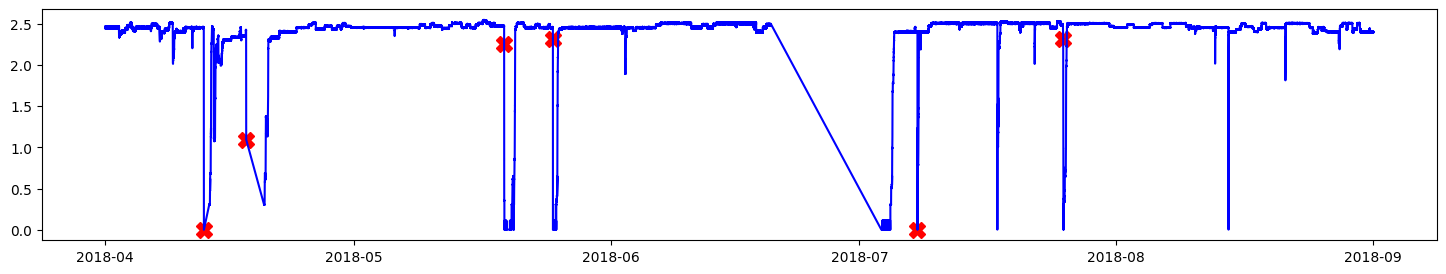

In [ ]:
# Plot time series for each sensor with BROKEN state marked with X in red color
plt.figure(figsize=(18, 3))
plt.plot(
    broken_sensors_df["timestamp"],
    broken_sensors_df["sensor_00"],
    linestyle="none",
    marker="X",
    color="red",
    markersize=12,
)
plt.plot(sensors_df["timestamp"], sensors_df["sensor_00"], color="blue")
plt.show()

We can see above that over time the sensor values stay generally around 2.5 with a few noisy dropoff spikes. We have plotted the column `machine_status=BROKEN` in red here which corresponds with a lot of these spikes indicating the reason for the dropoffs.

## 2. Create Sensor Vector Embeddings

Next, let's create embeddings for these values. To do this we use a combination of windowing and normalizing the data. We have chosen a simple approach that leverages the raw time series data directly, without the need for complex modelling or domain-specific expertise.

### Extract One Sensors Values

In [ ]:
sensor0_df = sensors_df[["timestamp", "sensor_00"]]
sensor0_df = sensor0_df.reset_index(drop=True).reset_index()

In [ ]:
# This is our sensor data to be ingested into KDB.AI
sensor0_df.head()

,index,timestamp,sensor_00
0,0,2018-04-01 00:00:00,2.465394
1,1,2018-04-01 00:01:00,2.465394
2,2,2018-04-01 00:02:00,2.444734
3,3,2018-04-01 00:03:00,2.460474
4,4,2018-04-01 00:04:00,2.445718


In [ ]:
sensor0_df.shape

(195815, 3)

### Group The Sensor0 Values into Time Windows

The code below divides the original time series data into overlapping windows, with each window containing a specified number of rows and a step size determining how they are shifted along the timeline. It also extracts a timestamp from each window as we will want to store this as metadata.

In [ ]:
# Set the window size (number of rows in each window)
window_size = 100
step_size = 1

In [ ]:
# define windows
windows = [
    sensor0_df.iloc[i : i + window_size]
    for i in range(0, len(sensor0_df) - window_size + 1, step_size)
]

In [ ]:
# Iterate through the windows & extract column values
start_times = [w["timestamp"].iloc[0] for w in windows]
end_times = [w["timestamp"].iloc[-1] for w in windows]
sensor0_values = [w["sensor_00"].tolist() for w in windows]

In [ ]:
# Create a new DataFrame from the collected data
embedding_df = pd.DataFrame(
    {"timestamp": start_times, "sensor_00": sensor0_values}
)

In [ ]:
embedding_df = embedding_df.reset_index(drop=True).reset_index()

In [ ]:
# Show the resulting DataFrame
show_df(embedding_df)

(195716, 3)


,index,timestamp,sensor_00
0,0,2018-04-01 00:00:00,"[2.465394, 2.465394, 2.444734, 2.460474, 2.445..."
1,1,2018-04-01 00:01:00,"[2.465394, 2.444734, 2.460474, 2.445718, 2.453..."
2,2,2018-04-01 00:02:00,"[2.444734, 2.460474, 2.445718, 2.453588, 2.455..."
3,3,2018-04-01 00:03:00,"[2.460474, 2.445718, 2.453588, 2.455556, 2.449..."
4,4,2018-04-01 00:04:00,"[2.445718, 2.453588, 2.455556, 2.449653, 2.463..."


In [ ]:
# When is the first time a sensor is 'broken'?
broken_sensors_df["timestamp"]

17125    2018-04-12 21:55:00
23564    2018-04-18 00:30:00
64962    2018-05-19 03:18:00
72865    2018-05-25 00:30:00
116910   2018-07-08 00:11:00
142214   2018-07-25 14:00:00
Name: timestamp, dtype: datetime64[ns]

## 3. Store Embeddings in KDB.AI

With the embeddings created, we need to store them in a vector database to enable efficient searching.

### Define KDB.AI Session

KDB.AI comes in two offerings:

1. [KDB.AI Cloud](https://trykdb.kx.com/kdbai/signup/) - For experimenting with smaller generative AI projects with a vector database in our cloud.
2. [KDB.AI Server](https://trykdb.kx.com/kdbaiserver/signup/) - For evaluating large scale generative AI applications on-premises or on your own cloud provider.

Depending on which you use there will be different setup steps and connection details required.

##### Option 1. KDB.AI Cloud

To use KDB.AI Cloud, you will need two session details - a URL endpoint and an API key.
To get these you can sign up for free [here](https://trykdb.kx.com/kdbai/signup).

You can connect to a KDB.AI Cloud session using `kdbai.Session` and passing the session URL endpoint and API key details from your KDB.AI Cloud portal.

If the environment variables `KDBAI_ENDPOINTS` and `KDBAI_API_KEY` exist on your system containing your KDB.AI Cloud portal details, these variables will automatically be used to connect.
If these do not exist, it will prompt you to enter your KDB.AI Cloud portal session URL endpoint and API key details.

In [ ]:
KDBAI_ENDPOINT = (
    os.environ["KDBAI_ENDPOINT"]
    if "KDBAI_ENDPOINT" in os.environ
    else input("KDB.AI endpoint: ")
)
KDBAI_API_KEY = (
    os.environ["KDBAI_API_KEY"]
    if "KDBAI_API_KEY" in os.environ
    else getpass("KDB.AI API key: ")
)

In [ ]:
session = kdbai.Session(api_key=KDBAI_API_KEY, endpoint=KDBAI_ENDPOINT)

##### Option 2. KDB.AI Server

To use KDB.AI Server, you will need download and run your own container.
To do this, you will first need to sign up for free [here](https://trykdb.kx.com/kdbaiserver/signup/).

You will receive an email with the required license file and bearer token needed to download your instance.
Follow instructions in the signup email to get your session up and running.

Once the [setup steps](https://code.kx.com/kdbai/gettingStarted/kdb-ai-server-setup.html) are complete you can then connect to your KDB.AI Server session using `kdbai.Session` and passing your local endpoint.

In [ ]:
# session = kdbai.Session(endpoint="http://localhost:8082")

### Define Vector DB Table Schema

The next step is to define a schema for our KDB.AI table where we will store our embeddings. Our table will have three colums: startTime, endTime, vectors.

In [ ]:
sensor_schema = dict(
    columns=[
        dict(
            name='index',
            pytype='int64'
            ),
        dict(
            name='timestamp',
            pytype='datetime64[ns]'
            ),
        dict(
            name='sensor_00',
            pytype='float64',
            vectorIndex=
                dict(
                    type='flat',
                    metric='L2',
                    ),
            embedding=
                dict(
                    dims=8,
                    type='tsc',
                    )
            )
        ]
    )


### Create Vector DB Table

Use the KDB.AI `create_table` function to create a table that matches the defined schema in the vector database.

In [ ]:
# First ensure the table does not already exist
try:
    session.table("sensors").drop()
    time.sleep(5)
except kdbai.KDBAIException:
    pass

In [ ]:
table = session.create_table("sensors", sensor_schema)

In [ ]:
table.query()

,index,timestamp,sensor_00


### Add Embedded Data to KDB.AI Table

When adding larger amounts of data, you may need insert data into an index in chunks. It is a good idea to first get an idea of how large the dataset to insert is.

In [ ]:
from tqdm import tqdm
n = 1000  # number of rows per batch

for i in tqdm(range(0, embedding_df.shape[0], n)):
    table.insert(embedding_df[i:i+n].reset_index(drop=True))

100%|██████████| 196/196 [01:29<00:00,  2.18it/s]


### Verify Data Has Been Inserted

Running `table.query()` should show us that data has been added.

In [ ]:
show_df(table.query())

(195716, 3)


,index,timestamp,sensor_00
0,0,2018-04-01 00:00:00,"[1.4063345, -0.46870223, 0.31257457, -0.223289..."
1,1,2018-04-01 00:01:00,"[1.4062358, -0.468803, 0.312469, -0.22342645, ..."
2,2,2018-04-01 00:02:00,"[1.406137, -0.4689038, 0.3123643, -0.2235623, ..."
3,3,2018-04-01 00:03:00,"[1.4062243, -0.4688188, 0.31246793, -0.2234897..."
4,4,2018-04-01 00:04:00,"[1.40617, -0.46887565, 0.3124155, -0.22357321,..."


## 4. Search For Similar Sequences To A Target Sensor Sequence

Now our data is loaded successfully, we can perform pattern matching on our historical sensor data using KDB.AI `search`.

### Define an Example Pattern to Query

The first step is to select a pattern that will be used to query.

We chose this by selecting a start time, filtering to get the vector's values for that record, and then storing this in a variable called `q`. Any pattern could be selected here.

The resulting query pattern is also displayed as a line plot for visual inspection and analysis.

In [ ]:
broken_sensors_df["timestamp"]

17125    2018-04-12 21:55:00
23564    2018-04-18 00:30:00
64962    2018-05-19 03:18:00
72865    2018-05-25 00:30:00
116910   2018-07-08 00:11:00
142214   2018-07-25 14:00:00
Name: timestamp, dtype: datetime64[ns]

In [ ]:
## This is our query vector, using the 700th sliding window as an example - should return the 700th entry in KDB.AI as closest match
q = embedding_df['sensor_00'][17100]
#q

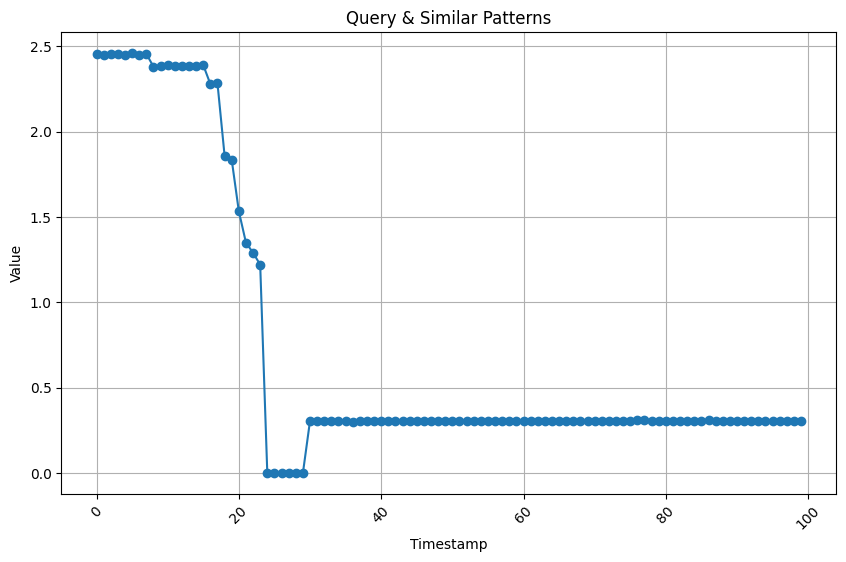

In [ ]:
# Visualise the example pattern
plt.figure(figsize=(10, 6))
plt.plot(embedding_df['sensor_00'][17100], marker="o", linestyle="-")
plt.xlabel("Timestamp")
plt.ylabel("Value")
plt.title("Query & Similar Patterns")
plt.grid(True)
plt.xticks(rotation=45)  # Rotate x-axis labels for readability
plt.show()

In [ ]:
nn1_result = table.search([q], n=100, filter=[(">","index", 18000)])
nn1_result[0]

,__nn_distance,index,timestamp
0,0.012005,64949,2018-05-19 03:05:00
1,0.012863,64948,2018-05-19 03:04:00
2,0.013482,72845,2018-05-25 00:10:00
3,0.013711,23540,2018-04-18 00:06:00
4,0.013956,23539,2018-04-18 00:05:00
...,...,...,...
95,0.122274,116879,2018-07-07 23:40:00
96,0.122840,64958,2018-05-19 03:14:00
97,0.125728,142194,2018-07-25 13:40:00
98,0.126511,72837,2018-05-25 00:02:00


In [ ]:
def filter_results(df, range_size=200):

    final_results = []
    removed_indices = set()

    for _, row in df.iterrows():
        current_index = row['index']

        # If this index hasn't been removed
        if current_index not in removed_indices:
            final_results.append(row)

            # Mark indices within range for removal
            lower_bound = max(0, current_index - range_size // 2)
            upper_bound = current_index + range_size // 2
            removed_indices.update(range(lower_bound, upper_bound + 1))

    # Create a new dataframe from the final results
    final_df = pd.DataFrame(final_results)

    return final_df

filtered_df = filter_results(nn1_result[0])

# Display the filtered results
print(filtered_df)

    __nn_distance   index           timestamp
0        0.012005   64949 2018-05-19 03:05:00
2        0.013482   72845 2018-05-25 00:10:00
3        0.013711   23540 2018-04-18 00:06:00
12       0.018191  142204 2018-07-25 13:50:00
27       0.027702  110667 2018-06-20 07:37:00
79       0.102172  116883 2018-07-07 23:44:00


In [ ]:
broken_sensors_df["timestamp"]

17125    2018-04-12 21:55:00
23564    2018-04-18 00:30:00
64962    2018-05-19 03:18:00
72865    2018-05-25 00:30:00
116910   2018-07-08 00:11:00
142214   2018-07-25 14:00:00
Name: timestamp, dtype: datetime64[ns]

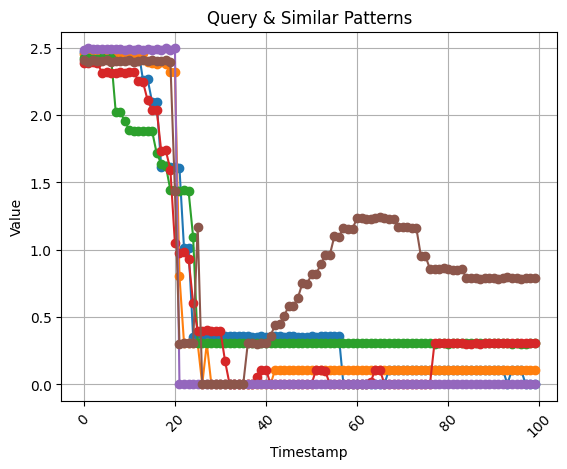

In [ ]:
for i in filtered_df['index']:
    plt.plot(embedding_df['sensor_00'][i], marker="o", linestyle="-")
plt.xlabel("Timestamp")
plt.ylabel("Value")
plt.title("Query & Similar Patterns")
plt.grid(True)
plt.xticks(rotation=45)  # Rotate x-axis labels for readability
plt.show()

## 5. Delete the KDB.AI Table

Once finished with the table, it is best practice to drop it.

In [ ]:
table.drop()

True

## Take Our Survey

We hope you found this sample helpful! Your feedback is important to us, and we would appreciate it if you could take a moment to fill out our brief survey. Your input helps us improve our content.

[**Take the Survey**](https://delighted.com/t/go0ElNsJ)